# Analysis of light curve periods

In this notebook I will describe the process for calculating the periods of `LINEAR` light curves and `ZTF` light curves using the *Lomb-Scargle periodogram*. Afterwards, we will save all of the periods and the number of observation points in a `DataFrame` which I will then analyze using descriptive statistics. 

In [2]:
# importing all of the necessary libraries
import numpy as np
#import seaborn as sns
import pandas as pd
import scipy as sc
import random
import pickle

from matplotlib import pyplot as plt
from scipy.stats import norm

from astroML.utils.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
#from gatspy import periodic
from astropy.timeseries import LombScargle
from astroML.datasets import fetch_LINEAR_sample

from ztfquery import lightcurve
from matplotlib import ticker
import dask.dataframe as dd 
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import threading
import os

np.random.seed(42)
%matplotlib inline  

In [20]:
sns.set_theme() # setting the theme for plotting

## What is the Lomb-Scargle periodogram?

The Lomb-Scargle method of computing the period of a variable star using light curves involves fitting multi-level sinusoidal waves to our light curve data over various trial periods, and the period with the largest strength or the best fit is the real period.

This is the formula for the Lomb-Scargle periodogram:

$$P(ω)= \frac{1}{2σ^2}​*(\frac{[∑y_k cosω(t_k−τ)]^2}{∑cos^2 ω(t_k−τ)} + \frac{[∑y_k sin ω(t_k−τ)]^2}{∑ sin^2 ω(t_k−τ)})$$

- $ω$ is the frequency we are testing to see if it matches with our light curve.
- $σ^2$ is the variance of the data. We are dividing by it to normalize the data to work across all distributions.
- $∑y_k cosω(t_k−τ)$ and $∑y_k sin ω(t_k−τ)$: checking how well the fitted cosine and sine waves align with the data. $t_k$ is the particular time point, and $τ$ is the time delay, for efficiency.
- $∑cos^2 ω(t_k−τ)$ and $∑ sin^2 ω(t_k−τ)$: normalization of the fitting, in order to eliminate bias towards very strong and/or weak wave components. 

## Why do I use the Lomb-Scargle periodogram?

We use the Lomb-Scargle periodogram because it is the most popular tool used for determining the period of periodic variable stars. It combines multiple methods of analysis, with it's core being in Fourier analysis, and the fact that it operates with non-uniformly spaced data, such is the nature of light curves.

## Calculating the periods

### `LINEAR` dataset

In [4]:
data = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library

### Example: light curve 10032668

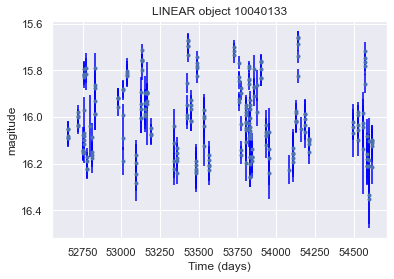

In [125]:
t, mag, mager = data.get_light_curve(data.ids[10]).T
fig, ax = plt.subplots()
ax.errorbar(t, mag, mager, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(data.ids[10]))
ax.invert_yaxis()

In [126]:
ls = LombScargle(t, mag, mager)
frequency, power = ls.autopower(nyquist_factor=500)

period_days = 1. / frequency

best_period = period_days[np.argmax(power)]
phase = (t / best_period) % 1
best_frequency = frequency[np.argmax(power)] # choosing the frequency with the highest power


In [127]:
best_period

0.6105450399303926

[(0.2, 1.4),
 (0.0, 0.8),
 Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Lomb-Scargle Power')]

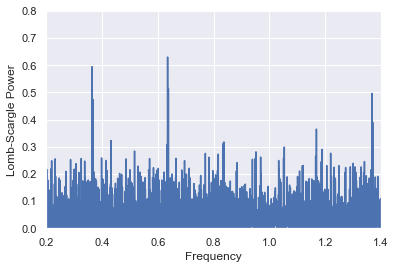

In [128]:
fig, ax = plt.subplots()
ax.plot(frequency, power)
ax.set(xlim=(0.2, 1.4), ylim=(0, 0.8),
       xlabel='Frequency',
       ylabel='Lomb-Scargle Power')

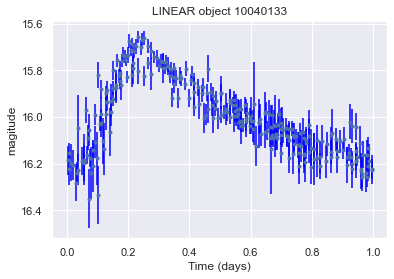

In [90]:
fig, ax = plt.subplots()
ax.errorbar(phase, mag, mager, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(data.ids[10]))
ax.invert_yaxis()

### Calculating LINEAR periods

In [129]:
LC_LINEAR = pd.DataFrame() # creating the empty DataFrame

for i in data.ids:
    t, mag, mager = data.get_light_curve(i).T # get the data for every light curve
    ls = LombScargle(t, mag, mager) # set up a LombScargle object to model the frequency and power
    frequency, power = ls.autopower(nyquist_factor=350) # calculate the frequency and power

    period = 1. / frequency # calculating the periods
    best_period = period[np.argmax(power)] # choosing the period with the highest power
    best_frequency = frequency[np.argmax(power)] # choosing the frequency with the highest power
    N = len(t) # number of points used in calculation

    lc_periods = pd.DataFrame([i, best_frequency, best_period, N]) # create Dataframe which you will append to main DataFrame
    lc_periods = lc_periods.transpose() # transpose in order to create a row of data
    columns = ['ID', 'Frequency','Period','N'] # determine columns
    lc_periods.columns = columns # assign columns
    LC_LINEAR = pd.concat([LC_LINEAR, lc_periods], axis=0) # concatenate tables 
    print(f'Current ID:{i}') # print current ID

Current ID:10003298
Current ID:10004892
Current ID:10013411
Current ID:10021274
Current ID:10022663
Current ID:10025796
Current ID:10028253
Current ID:10030349
Current ID:10032668
Current ID:10038903
Current ID:10040133
Current ID:10040491
Current ID:10045187
Current ID:10045615
Current ID:10046720
Current ID:10047498
Current ID:1004849
Current ID:1005497
Current ID:10064356
Current ID:10066464
Current ID:10071455
Current ID:10084768
Current ID:10085065
Current ID:10086396
Current ID:10089441
Current ID:1009459
Current ID:10099492
Current ID:10100966
Current ID:10101561
Current ID:10102166
Current ID:10113493
Current ID:10114059
Current ID:10116555
Current ID:10123919
Current ID:10127760
Current ID:10127904
Current ID:10132759
Current ID:1013374
Current ID:10135800
Current ID:1013889
Current ID:10141859
Current ID:1014960
Current ID:10157893
Current ID:10164624
Current ID:10166691
Current ID:10178590
Current ID:10178648
Current ID:10183351
Current ID:1018967
Current ID:1019294
Current 

In [130]:
LC_LINEAR

,ID,Frequency,Period,N
0,10003298.0,8.067333,0.123957,196.0
0,10004892.0,1.486845,0.672565,269.0
0,10013411.0,1.800789,0.555312,170.0
0,10021274.0,1.733287,0.576939,214.0
0,10022663.0,1.623512,0.615949,246.0
...,...,...,...,...
0,9983476.0,2.252320,0.443987,286.0
0,9983939.0,2.231729,0.448083,466.0
0,9984569.0,2.867441,0.348743,478.0
0,9987252.0,0.800516,1.249194,404.0


### `ZTF` dataset

In [3]:
ZTF_data = np.load('../inputs/ZTF_curves.npy', allow_pickle=True) # loading the data

### Example: Light curve 5

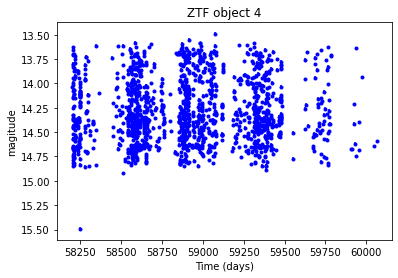

In [11]:
t, mag, mager = ZTF_data[4][1]['mjd'], ZTF_data[4][1]['mag'],ZTF_data[4][1]['magerr']
fig, ax = plt.subplots()
ax.errorbar(t, mag, mager, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='ZTF object {0}'.format(4))
ax.invert_yaxis()

In [12]:
ls = LombScargle(t, mag, mager)
frequency, power = ls.autopower(nyquist_factor=500,
                                minimum_frequency=0.2)

period_days = 1. / frequency

best_period = period_days[np.argmax(power)]
phase = (t / best_period) % 1
best_frequency = frequency[np.argmax(power)] # choosing the frequency with the highest power

[(0.2, 1.4),
 (0.0, 0.8),
 Text(0.5, 0, 'Frequency'),
 Text(0, 0.5, 'Lomb-Scargle Power')]

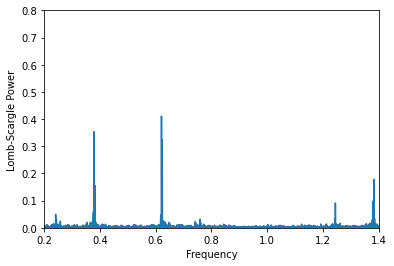

In [13]:
fig, ax = plt.subplots()
ax.plot(frequency, power)
ax.set(xlim=(0.2, 1.4), ylim=(0, 0.8),
       xlabel='Frequency',
       ylabel='Lomb-Scargle Power')

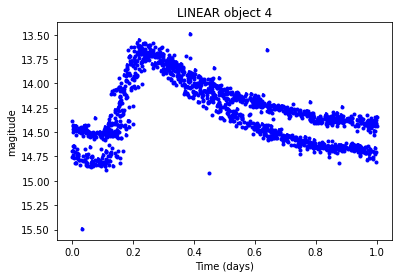

In [14]:
fig, ax = plt.subplots()
ax.errorbar(phase, mag, mager, fmt='.b', ecolor='blue')
ax.set(xlabel='Time (days)', ylabel='magitude',
       title='LINEAR object {0}'.format(4))
ax.invert_yaxis()

In [15]:
best_period

0.6159413663822884

### Calculating ZTF periods

In [16]:
num = [x for x in range(7010)]

In [17]:
LC_ZTF = pd.DataFrame() # creating the empty DataFrame

for i in num:
    if ZTF_data[i][1].shape[0] > 0:
        t, mag, mager = ZTF_data[i][1]['mjd'], ZTF_data[i][1]['mag'],ZTF_data[i][1]['magerr'] # get the data for every light curve
        ls = LombScargle(t, mag, mager) # set up a LombScargle object to model the frequency and power
        f, p = ls.autopower(nyquist_factor=350) # calculate the frequency and power

        period = 1. / f # calculating the periods
        best_p = p[np.argmax(p)] # choosing the period with the highest power
        best_f = f[np.argmax(p)] # choosing the frequency with the highest power
        N = len(t) # number of points used in calculation

        lc_p_ztf = pd.DataFrame([i, best_f, best_p, N]) # create Dataframe which you will append to main DataFrame
        lc_p_ztf = lc_p_ztf.transpose() # transpose in order to create a row of data
        columns = ['ID', 'Frequency','Period','N'] # determine columns
        lc_p_ztf.columns = columns # assign columns
        LC_ZTF = pd.concat([LC_ZTF, lc_p_ztf], axis=0) # concatenate tables 
        print(f'Current ID:{i}') # print current ID
    else:
        lc_p_ztf = pd.DataFrame()
        LC_ZTF = pd.concat([LC_ZTF, lc_p_ztf], axis=0)
        print(f'Current ID:{i}') # print current ID

LC_ZTF.reset_index(drop=True, inplace=True)

Current ID:0
Current ID:1
Current ID:2
Current ID:3
Current ID:4
Current ID:5
Current ID:6
Current ID:7
Current ID:8
Current ID:9
Current ID:10
Current ID:11
Current ID:12
Current ID:13
Current ID:14
Current ID:15
Current ID:16
Current ID:17
Current ID:18
Current ID:19
Current ID:20
Current ID:21
Current ID:22
Current ID:23
Current ID:24
Current ID:25
Current ID:26
Current ID:27
Current ID:28
Current ID:29
Current ID:30
Current ID:31
Current ID:32
Current ID:33
Current ID:34
Current ID:35
Current ID:36
Current ID:37
Current ID:38
Current ID:39
Current ID:40
Current ID:41
Current ID:42
Current ID:43
Current ID:44
Current ID:45
Current ID:46
Current ID:47
Current ID:48
Current ID:49
Current ID:50
Current ID:51
Current ID:52
Current ID:53
Current ID:54
Current ID:55
Current ID:56
Current ID:57
Current ID:58
Current ID:59
Current ID:60
Current ID:61
Current ID:62
Current ID:63
Current ID:64
Current ID:65
Current ID:66
Current ID:67
Current ID:68
Current ID:69
Current ID:70
Current ID:71
Cu

In [29]:
LC_ZTF.reset_index(drop=True, inplace=True)

In [30]:
LC_ZTF

,ID,Frequency,Period,N
0,0.0,8.067305,0.078646,2197.0
1,1.0,2.489658,0.655841,39.0
2,2.0,2.800860,0.053510,1404.0
3,3.0,1.733282,0.645009,1995.0
4,4.0,1.623467,0.578431,1533.0
...,...,...,...,...
6827,7004.0,3.201690,0.770133,546.0
6828,7006.0,2.231881,0.694322,553.0
6829,7007.0,2.867459,0.557196,549.0
6830,7008.0,1.803291,0.561482,547.0


In [31]:
LC_ZTF.to_csv('../outputs/ZTF.csv', index=False)

In [25]:
LC_LINEAR = pd.read_csv("../outputs/LINEAR.csv")

In [26]:
LC_PERIODS = pd.concat([LC_LINEAR, LC_ZTF], axis=0)

In [27]:
LC_PERIODS

,Unnamed: 0,ID,Frequency,Period,N
0,0.0,10003298.0,8.067333,0.123957,196.0
1,0.0,10004892.0,1.486845,0.672565,269.0
2,0.0,10013411.0,1.800789,0.555312,170.0
3,0.0,10021274.0,1.733287,0.576939,214.0
4,0.0,10022663.0,1.623512,0.615949,246.0
...,...,...,...,...,...
0,NaN,7004.0,3.201690,0.770133,546.0
0,NaN,7006.0,2.231881,0.694322,553.0
0,NaN,7007.0,2.867459,0.557196,549.0
0,NaN,7008.0,1.803291,0.561482,547.0


## Analysis of the periods of the light curves

## Plotting examples of phased light curves from both `LINEAR` and `ZTF`